
Going through Eric's code to figure out what it is doing

In [1]:
import numpy as np
import scipy.optimize as op
import pdb
import matplotlib.pyplot as pl
import pickle as pk
import scipy.optimize as op
import emcee
from scipy import stats
from astropy.io import fits
%matplotlib inline

import numpy as np
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.signal as sig
import scipy.special as sp
import pdb


# First do Sigmag, fiducial measurement

### Read in file

In [2]:
infile = np.load('../cc_measurements/final/splashback_cov_l20_100_fiducial_bin20.npz')

### Model and data setting

In [3]:
h0 = 0.7
minR_withh = 0.1
maxR_withh = 10.0

#log alpha, log rho_s, log rho_0, log r_s, s_e, log r_t, log beta, log gamma, f_mis, lnc_mis
p0_splash = np.array([-0.7233399 ,  1.2320193 - 0.3 , -0.81458972 - 0.3, -0.46549158,  1.62975201,     0.30102756,  0.6082444 ,  0.84419774,  0.2570068 , -1.15657301])
p0_nosplash = np.array([-1.08884226, 1.50498118, -0.78881006,-0.60631178,  1.58169303,  0.22  , -1.13 ])

#model choices
make_plot = True
do_mcmc = True
with_splashback = True
do_miscentering = True
is_deltasigma = False

miscentering_prior_type = 'freedes' #none, fixeddes, fixedsdss, freedes, freesdss, freesdssaggressive, freesdssloose
alpha_prior_type = 'normal' #normal or tight
profile_type = 'dk' #dk or nfw
z_max = 40./h0

#Bounds
bound_alpha = (-5, 5.)
bound_rho_s = (None, None)
bound_rho_0 = (None, None)
bound_r_s = (np.log10(0.1/h0), np.log10(5.0/h0))
bound_s_e = (-6., 6.)
bound_r_t = (np.log10(0.1/h0), np.log10(5.0/h0))
bound_beta = (None, None)
bound_gamma = (None, None)
bound_fmis = (0.01, 0.99)
bound_lnc = (-20., 5.)

bounds_splash = (bound_alpha, bound_rho_s, bound_rho_0, bound_r_s, bound_s_e, bound_r_t, bound_beta, \
                 bound_gamma, bound_fmis, bound_lnc)
bounds_nosplash = (bound_alpha, bound_rho_s, bound_rho_0, bound_r_s, bound_s_e, bound_fmis, bound_lnc)

In [4]:
R_vec_orig = infile['r_data']
data_vec_orig = infile['sg_mean']
cov_orig = infile['cov']
R_lambda = infile['mean_rlambda_com']

#Restrict data
good_range = np.where((R_vec_orig*h0 > minR_withh) & (R_vec_orig*h0 < maxR_withh))[0]
R_vec = R_vec_orig[good_range]
data_vec = data_vec_orig[good_range]
cov = (cov_orig[good_range,:])[:,good_range]
detcov = np.linalg.det(cov) # determinant 
invcov = np.linalg.inv(cov) # inverse covariane

### Compile model and data in fo to go in the rest of the code

In [5]:
model_info = {'h0':h0, 'with_splashback':with_splashback, 'profile_type':profile_type, \
              'miscentering_prior_type':miscentering_prior_type, 'do_miscentering':do_miscentering,\
              'alpha_prior_type':alpha_prior_type, 'z_max':z_max, 'is_deltasigma':is_deltasigma, 'R_lambda':R_lambda}

data_info = {'rad_vec':R_vec, 'data_vec':data_vec, 'invcov':invcov, 'detcov':detcov}

### Plot the data and covariance

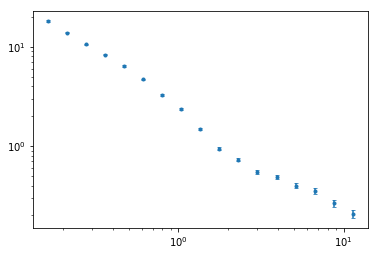

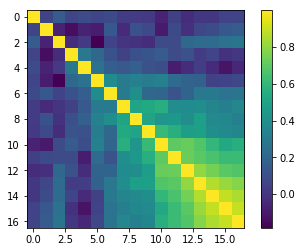

In [6]:
pl.figure()
pl.errorbar(R_vec, data_vec, yerr=np.diag(cov)**0.5, marker='.', fmt='.', capthick=0.8, capsize=2.2)
pl.xscale('log')
pl.yscale('log')

cov_norm = cov.copy()
for i in range(len(cov)):
    for j in range(len(cov)):
        cov_norm[i][j] /= (cov[i][i]*cov[j][j])**0.5

pl.figure()
pl.imshow(cov_norm)
pl.colorbar()

### Define $\rho(r)$

In [7]:
def rho_profile(rr, params, model_info):
    h0 = model_info['h0']
    with_splashback = model_info['with_splashback']
    profile_type = model_info['profile_type']
    miscentering_prior_type = model_info['miscentering_prior_type']
    alpha_prior_type = model_info['alpha_prior_type']

    if (profile_type == 'dk'):
        r_out = 1.5/h0
        alpha = 10.**params[0]
        rho_s = 10.**params[1]
        rho_0 = 10.**params[2]
        r_s = 10.**params[3]
        s_e = params[4]
        rho_inner = rho_s*np.exp(-(2./alpha)*((rr/r_s)**alpha - 1.))
    if (profile_type == 'nfw'):
        alpha = 10.**params[0]
        rho_s = 10.**params[1]
        rho_0 = 10.**params[2]
        r_s = 10.**params[3]
        s_e = params[4]
        rho_inner = rho_s/(((rr/r_s)**alpha)*(1.+rr/r_s)**(3.-alpha))

    if (with_splashback):
        r_t = 10.**params[5]
        beta = 10.**params[6]
        gamma = 10.**params[7]
        f_trans = (1. + (rr/r_t)**beta)**(-gamma/beta)
    else:
        f_trans = 1.0
    
    rho_outer = rho_0*(rr/r_out)**(-s_e)
    rho = rho_inner*f_trans + rho_outer

    return rho, rho_inner*f_trans, rho_outer, f_trans

### Define $\Sigma$

In [18]:
def sigma_profile(params, R_array, model_info):
    with_splashback = model_info['with_splashback']
    profile_type = model_info['profile_type']
    miscentering_prior_type = model_info['miscentering_prior_type']
    alpha_prior_type = model_info['alpha_prior_type']
    z_max = model_info['z_max']
    
    sigma = np.zeros(len(R_array))
    #7777777777777777
    if (1):
        minz_to_integrate = 0.001
        maxz_to_integrate = z_max
        num_z_tointegrate = 500
        z_tointegrate = np.exp(np.linspace(np.log(minz_to_integrate), np.log(maxz_to_integrate), num = num_z_tointegrate))
    if (0):
        minz_to_integrate = 0.0
        maxz_to_integrate = z_max
        num_z_tointegrate = 1000
        z_tointegrate = np.linspace(minz_to_integrate, maxz_to_integrate, num = num_z_tointegrate)
    dz = z_tointegrate[1:] - z_tointegrate[:-1]
    for ri in range(0,len(R_array)):
        rr = np.sqrt(R_array[ri]**2. + z_tointegrate**2.)
        rho, term1, term2, term3 = rho_profile(rr, params, model_info)
        # twice since integral is symmetric and want -infty to +infty
        #sigma[ri] = 2.*integrate.simps(rho, z_tointegrate)
        sigma[ri] = 2.*np.sum(0.5*dz*(rho[1:] + rho[:-1]))
    return sigma

### Define $\Sigma_{mis}$

In [20]:
def sigma_miscentered(R_output, R_sigma, Sigma, f_mis, lnc_mis, R_lambda):
    Sigma_mis = np.zeros(len(R_output))

    c_mis = np.exp(lnc_mis)
    sigma_R = c_mis*R_lambda

    lnSigma_func = interpolate.interp1d(np.log(R_sigma), np.log(Sigma), fill_value = "extrapolate")

    #77777777777777777
    min_theta = 0.
    max_theta = 2.*np.pi
    num_theta = 50#100
    theta = np.linspace(min_theta, max_theta, num = num_theta)
    dtheta = theta[1:] - theta[:-1]

    min_R_mis = 0.
    max_R_mis = 4.5*sigma_R
    num_R_mis = 50#100
    R_mis = np.linspace(min_R_mis, max_R_mis, num = num_R_mis)
    dR_mis = R_mis[1:] - R_mis[:-1]

    #P(R_mis)
    #extra factor of R_mis since 2D gaussian
    Gaussian = (1./(sigma_R**2.))*R_mis*np.exp(-0.5*(R_mis**2.)/(sigma_R**2.))

    theta_mat = np.tile(theta,(num_R_mis,1))
    R_mis_mat = np.tile(R_mis,(num_theta,1)).transpose()
    Gaussian_mat = np.tile(Gaussian,(num_theta,1)).transpose()
    cos_theta_mat = np.cos(theta_mat)

    for ri in range(0,len(R_output)):
        Sigma_mat = np.exp(lnSigma_func(np.log(np.sqrt(R_output[ri]**2. + R_mis_mat**2. + 2.*R_output[ri]*R_mis_mat*cos_theta_mat))))
        tointegrate_mat = Gaussian_mat*Sigma_mat
        Sigma_mis[ri] = (1./(2.*np.pi))*dtheta[0]*dR_mis[0]*np.trapz(np.trapz(tointegrate_mat, axis = 1), axis = 0)

    return Sigma_mis

### Putting everything together

In [10]:
def sigma_model(params, R_array, model_info):
    h0 = model_info['h0']
    with_splashback = model_info['with_splashback']
    profile_type = model_info['profile_type']
    do_miscentering = model_info['do_miscentering']
    miscentering_prior_type = model_info['miscentering_prior_type']
    alpha_prior_type = model_info['alpha_prior_type']
    R_lambda = model_info['R_lambda']

    if (do_miscentering):
        f_mis = params[-2]
        lnc_mis = params[-1]
        min_R_temp = 0.01
        max_R_temp = 1.2*np.max(R_array)
        num_R_temp = len(R_array)+100
        R_temp = np.exp(np.linspace(np.log(min_R_temp), np.log(max_R_temp), num = num_R_temp))
        sigma_at_R = sigma_profile(params, R_array, model_info)
        #miscentering
        sigma_model_nomiscentering = sigma_profile(params, R_temp, model_info)
        sigma_miscentered_at_R = sigma_miscentered(R_array, R_temp, sigma_model_nomiscentering, f_mis, lnc_mis, R_lambda)
        sigma_model = (1.-f_mis)*sigma_at_R + f_mis*sigma_miscentered_at_R
    else:
        sigma_model = sigma_profile(params, R_array, model_info)
        
    return sigma_model

### Getting priors

In [11]:
def get_priors(param_vec, model_info):

    miscentering_prior_type = model_info['miscentering_prior_type']
    do_miscentering = model_info['do_miscentering']
    alpha_prior_type = model_info['alpha_prior_type']
    with_splashback = model_info['with_splashback']

    min_logrs = np.log10(0.1/0.7)
    max_logrs = np.log10(5.0/0.7) 
    min_logrt = np.log10(0.1/0.7)
    max_logrt = np.log10(5.0/0.7) 
    min_se = 1.0
    max_se = 10.0

    logalpha = param_vec[0]
    logrho_s = param_vec[1]
    logrho_0 = param_vec[2]
    logr_s = param_vec[3]
    s_e = param_vec[4]

    # flat priors
    if ((logr_s < min_logrs) or (logr_s > max_logrs)):
        lnprior_rs = -1.0e10
    else:
        lnprior_rs =  np.log(1./(max_logrs-min_logrs))
    if ((s_e < min_se) or (s_e > max_se)):
        lnprior_se = -1.0e10
    else:
        lnprior_se = np.log(1./(max_se - min_se))

    mean_logalpha = np.log10(0.19)
    if (alpha_prior_type == 'normal'):
        sigma_logalpha = 0.2
    if (alpha_prior_type == 'tight'):
        sigma_logalpa = 0.1
        
    # gaussian prior on log alpha
    lnnorm_logalpha = -np.log(np.sqrt(2.*(sigma_logalpha**2.)*np.pi))
    lnprior_alpha = lnnorm_logalpha-0.5*((logalpha - mean_logalpha)**2.)/sigma_logalpha**2.

    lnprior_splash = 0.0
    if (with_splashback):
        logr_t = param_vec[5]
        logbeta = param_vec[6]
        loggamma = param_vec[7]
        lnprior_rt = 0.0
        lnprior_beta = 0.0
        lnprior_gamma = 0.0
        if ((logr_t > max_logrt) or (logr_t < min_logrt)):
            lnprior_rt = -1.0e10
        else:
            #normalization
            lnprior_rt = np.log(1./(max_logrt - min_logrt))
            mean_logbeta = np.log10(4.)
            sigma_logbeta = 0.2
            lnnorm_logbeta = -np.log(np.sqrt(2.*(sigma_logbeta**2.)*np.pi))
            mean_loggamma = np.log10(6.0)
            sigma_loggamma = 0.2
            lnnorm_loggamma = -np.log(np.sqrt(2.*(sigma_loggamma**2.)*np.pi))
            lnprior_beta =  lnnorm_logbeta -0.5*((logbeta - mean_logbeta)**2.)/sigma_logbeta**2.
            lnprior_gamma = lnnorm_loggamma -0.5*((loggamma - mean_loggamma)**2.)/sigma_loggamma**2.
        
        # prior is basically adding up the different components, all priors are normalized
        lnprior_splash = lnprior_rt + lnprior_beta + lnprior_gamma

    lnprior_miscentering = 0.0
    if (do_miscentering):
        f_mis = param_vec[-2]
        lnc_mis = param_vec[-1]

        if ((f_mis < 0.01) or (f_mis > 0.99) or (lnc_mis < -20.) or (lnc_mis > 5.0)):
            lnprior_miscentering = -1.0e10
        else:
            # DES
            if (miscentering_prior_type == 'freedes'):
                mean_lncmis = -1.13
                sigma_lncmis = 0.22
                mean_fmis = 0.22
                sigma_fmis = 0.11
            # SDSS
            if (miscentering_prior_type == 'freesdss'):
                mean_lncmis = -0.916
                sigma_lncmis = 0.22
                mean_fmis = 0.2
                sigma_fmis = 0.07
            if (miscentering_prior_type == 'freesdssloose'):
                mean_lncmis = -0.916
                sigma_lncmis = 0.44
                mean_fmis = 0.2
                sigma_fmis = 0.14
            lnnorm_lncmis = -np.log(np.sqrt(2.*(sigma_lncmis**2.)*np.pi))
            lnnorm_fmis = -np.log(np.sqrt(2.*(sigma_fmis**2.)*np.pi))
            lnprior_lncmis = lnnorm_lncmis -0.5*((lnc_mis - mean_lncmis)**2.)/sigma_lncmis**2.
            lnprior_fmis = lnnorm_fmis -0.5*((f_mis - mean_fmis)**2.)/sigma_fmis**2.
            lnprior_miscentering = lnprior_lncmis + lnprior_fmis

    lnpriors = lnprior_rs + lnprior_se + lnprior_alpha + lnprior_splash + lnprior_miscentering

    return lnpriors

### Getting posterior

In [14]:
def lnposterior_sigma(param_vec, data_info, model_info, return_model = False):
    print("param vec = ", param_vec)
    rad_vec = data_info['rad_vec']
    data_vec = data_info['data_vec']
    invcov = data_info['invcov']
    detcov = data_info['detcov']

    #Get Sigma(R) model
    model = sigma_model(param_vec, rad_vec, model_info)

    #Calculate likelihood
    diff = data_vec - model
    lnlike = -0.5*(len(data_vec)*np.log(2.*np.pi) + np.log(detcov)) -0.5*np.dot(diff, np.dot(invcov, diff))

    #Calculate priors
    lnpriors = get_priors(param_vec, model_info)

    lnposterior = lnlike + lnpriors
    print("lnposterior = ", lnposterior)
    if (not return_model):
        return lnposterior
    else:
        R_hires = np.exp(np.linspace(np.log(0.5*np.min(rad_vec)), np.log(2.*np.max(rad_vec)), num = 500))
        model_hires = sigma_model(param_vec, R_hires, model_info)
        return lnposterior, R_hires, model_hires

### Get logarithmeic slope

In [15]:
# Get logarithmic slope of model
def get_slope_sg(r, sigma):

    lnsigma_lnr_spline = interpolate.interp1d(np.log(r), np.log(sigma), kind = 'cubic')
    numsmooth = 1000
    lnrad_fine = np.linspace(np.log(np.min(r)), np.log(np.max(r)), num = numsmooth)
    lnsigma_fine = lnsigma_lnr_spline(lnrad_fine)
    
    #Calculate derivative using finite differences
    dlnsig_dlnr_fine = (lnsigma_fine[1:] - lnsigma_fine[:-1])/(lnrad_fine[1:] -lnrad_fine[:-1])
    lnrad_out = (lnrad_fine[:-1]+lnrad_fine[1:])/2

    return lnrad_out, dlnsig_dlnr_fine

In [16]:
if (with_splashback):
    p0 = np.copy(p0_splash)
    bounds = bounds_splash
else:
    p0 = np.copy(p0_nosplash)
    bounds_nosplash

    #Do max likelihood calculation
args = (data_info, model_info)
nll = lambda *args: -1*lnposterior_sigma(*args)

In [21]:
method = 'SLSQP'
result = op.minimize(nll, p0, args=args, method = method, options = {'maxiter':100}, bounds = bounds)

param vec =  [-0.7233399   0.9320193  -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  0.2570068  -1.15657301]
lnposterior =  13.31861916969891
param vec =  [-0.7233399   0.9320193  -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  0.2570068  -1.15657301]
lnposterior =  13.31861916969891
param vec =  [-0.72333989  0.9320193  -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  0.2570068  -1.15657301]
lnposterior =  13.318619976919079
param vec =  [-0.7233399   0.93201931 -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  0.2570068  -1.15657301]
lnposterior =  13.31861922272084
param vec =  [-0.7233399   0.9320193  -1.11458971 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  0.2570068  -1.15657301]
lnposterior =  13.31861847800457
param vec =  [-0.7233399   0.9320193  -1.11458972 -0.46549157  1.62975201  0.30102756
  0.6082444   0.84419774  0.2570068  -1.15657301]
lnposterior =  13.

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


lnposterior =  -10000168590.984205
param vec =  [-0.15100591  1.28784346 -5.75647185 -0.50345223  0.86677681  0.186415
 -9.7709795   5.17265107  0.23230612 -1.78074542]
lnposterior =  -10000011233.637897
param vec =  [-0.6661065   0.96760172 -1.57877793 -0.46928764  1.55345449  0.2895663
 -0.42967799  1.27704307  0.25453673 -1.21899025]
lnposterior =  -8192.201433764536
param vec =  [-0.71761656  0.93557754 -1.16100854 -0.46587119  1.62212226  0.29988143
  0.50445216  0.88748227  0.25675979 -1.16281473]
lnposterior =  -24.27856116059128
param vec =  [-0.72250419  0.93253887 -1.12136768 -0.46554701  1.62863793  0.30086021
  0.59308892  0.85051804  0.25697073 -1.15748441]
lnposterior =  14.687377021271484
param vec =  [-0.72250419  0.93253887 -1.12136768 -0.46554701  1.62863793  0.30086021
  0.59308892  0.85051804  0.25697073 -1.15748441]
lnposterior =  14.687377021271484
param vec =  [-0.72250418  0.93253887 -1.12136768 -0.46554701  1.62863793  0.30086021
  0.59308892  0.85051804  0.256

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


lnposterior =  16.786739496254015
param vec =  [-0.72227435  0.94556728 -1.13080293 -0.46549402  1.62833155  0.30081418
  0.56258053  0.86312769  0.25696081 -1.15824121]
lnposterior =  16.786741513611503
param vec =  [-0.72227435  0.94556728 -1.13080293 -0.46549402  1.62833153  0.30081419
  0.56258053  0.86312769  0.25696081 -1.15824121]
lnposterior =  16.786741803279405
param vec =  [-0.72227435  0.94556728 -1.13080293 -0.46549402  1.62833153  0.30081418
  0.56258054  0.86312769  0.25696081 -1.15824121]
lnposterior =  16.786741528135238
param vec =  [-0.72227435  0.94556728 -1.13080293 -0.46549402  1.62833153  0.30081418
  0.56258053  0.86312771  0.25696081 -1.15824121]
lnposterior =  16.786742111641264
param vec =  [-0.72227435  0.94556728 -1.13080293 -0.46549402  1.62833153  0.30081418
  0.56258053  0.86312769  0.25696083 -1.15824121]
lnposterior =  16.786740616581145
param vec =  [-0.72227435  0.94556728 -1.13080293 -0.46549402  1.62833153  0.30081418
  0.56258053  0.86312769  0.25

lnposterior =  20.825739699255575
param vec =  [-0.65926186  0.99440267 -1.14593499 -0.47318413  1.5532113   0.29441979
  0.49144345  0.69825499  0.25195782 -1.03348592]
lnposterior =  20.82573973544766
param vec =  [-3.80534715  2.23842694 -1.30614847 -0.84509804  0.94788621 -0.84509804
  1.68975405  4.29986553  0.01        5.        ]
lnposterior =  -10000008874.53141
param vec =  [-0.97387039  1.1188051  -1.16195634 -0.51037552  1.49267879  0.18046801
  0.61127451  1.05841604  0.22776203 -0.43013734]
lnposterior =  -72.95700221406253
param vec =  [-0.69072271  1.00684291 -1.14753713 -0.47690327  1.54715805  0.28302461
  0.50342656  0.73427109  0.24953824 -0.97315108]
lnposterior =  21.775510615508246
param vec =  [-0.69072271  1.00684291 -1.14753713 -0.47690327  1.54715805  0.28302461
  0.50342656  0.73427109  0.24953824 -0.97315108]
lnposterior =  21.775510615508246
param vec =  [-0.6907227   1.00684291 -1.14753713 -0.47690327  1.54715805  0.28302461
  0.50342656  0.73427109  0.249

lnposterior =  24.287543098802562
param vec =  [-0.82900167  1.08057165 -1.11746891 -0.53589798  1.60075048  0.28919731
  0.59656823  0.86176017  0.21115777 -1.07547699]
lnposterior =  24.287543566250477
param vec =  [-0.82900167  1.08057165 -1.11746891 -0.53589798  1.60075048  0.28919731
  0.59656823  0.86176016  0.21115778 -1.07547699]
lnposterior =  24.28754311131187
param vec =  [-0.82900167  1.08057165 -1.11746891 -0.53589798  1.60075048  0.28919731
  0.59656823  0.86176016  0.21115777 -1.07547697]
lnposterior =  24.287543506058874
param vec =  [-0.43631078  1.93136565 -1.18104945 -0.84509804  1.36502987  0.34572763
  0.44991704  0.73010929  0.59901504 -0.72903336]
lnposterior =  -1124.8921924862366
param vec =  [-0.78973258  1.16565105 -1.12382697 -0.56681799  1.57717842  0.29485034
  0.58190312  0.84859507  0.24994349 -1.04083262]
lnposterior =  24.45044787373621
param vec =  [-0.78973258  1.16565105 -1.12382697 -0.56681799  1.57717842  0.29485034
  0.58190312  0.84859507  0.249

lnposterior =  25.41197536913284
param vec =  [-0.84427891  1.17072656 -1.11088842 -0.58147649  1.5934184   0.25838761
  0.67639211  0.88199975  0.20220966 -1.03453302]
lnposterior =  25.41197527341752
param vec =  [-0.84427891  1.17072656 -1.11088842 -0.58147649  1.5934184   0.25838761
  0.6763921   0.88199976  0.20220966 -1.03453302]
lnposterior =  25.411974917918624
param vec =  [-0.84427891  1.17072656 -1.11088842 -0.58147649  1.5934184   0.25838761
  0.6763921   0.88199975  0.20220968 -1.03453302]
lnposterior =  25.411974533045672
param vec =  [-0.84427891  1.17072656 -1.11088842 -0.58147649  1.5934184   0.25838761
  0.6763921   0.88199975  0.20220966 -1.034533  ]
lnposterior =  25.411974913007462
param vec =  [-0.85598426  1.23532758 -1.12194083 -0.60812739  1.56948653  0.26310126
  0.67242657  0.8675937   0.20712398 -1.0201246 ]
lnposterior =  25.642098921024996
param vec =  [-0.85598426  1.23532758 -1.12194083 -0.60812739  1.56948653  0.26310126
  0.67242657  0.8675937   0.2071

lnposterior =  25.875735258792503
param vec =  [-0.89500496  1.39203421 -1.12364085 -0.68071373  1.56701802  0.24821565
  0.69676516  0.83948773  0.22713124 -1.05606426]
lnposterior =  25.87573519879702
param vec =  [-0.89500497  1.39203423 -1.12364085 -0.68071373  1.56701802  0.24821565
  0.69676516  0.83948773  0.22713124 -1.05606426]
lnposterior =  25.87573606591357
param vec =  [-0.89500497  1.39203421 -1.12364084 -0.68071373  1.56701802  0.24821565
  0.69676516  0.83948773  0.22713124 -1.05606426]
lnposterior =  25.87573542265486
param vec =  [-0.89500497  1.39203421 -1.12364085 -0.68071371  1.56701802  0.24821565
  0.69676516  0.83948773  0.22713124 -1.05606426]
lnposterior =  25.875737017191636
param vec =  [-0.89500497  1.39203421 -1.12364085 -0.68071373  1.56701804  0.24821565
  0.69676516  0.83948773  0.22713124 -1.05606426]
lnposterior =  25.87573536706034
param vec =  [-0.89500497  1.39203421 -1.12364085 -0.68071373  1.56701802  0.24821567
  0.69676516  0.83948773  0.227131

lnposterior =  25.98491936407496
param vec =  [-0.86273322  1.45638468 -1.12057269 -0.70550353  1.57218485  0.25104143
  0.70886705  0.8627328   0.24975404 -1.0476263 ]
lnposterior =  25.984919277261653
param vec =  [-0.86273322  1.45638468 -1.12057269 -0.70550353  1.57218485  0.25104143
  0.70886705  0.86273278  0.24975406 -1.0476263 ]
lnposterior =  25.98491934633536
param vec =  [-0.86273322  1.45638468 -1.12057269 -0.70550353  1.57218485  0.25104143
  0.70886705  0.86273278  0.24975404 -1.04762629]
lnposterior =  25.98491930482637
param vec =  [-0.85222302  1.46313963 -1.12161391 -0.70732343  1.57118494  0.24891533
  0.7127819   0.85276605  0.25425564 -1.04860664]
lnposterior =  26.000810506930808
param vec =  [-0.85222302  1.46313963 -1.12161391 -0.70732343  1.57118494  0.24891533
  0.7127819   0.85276605  0.25425564 -1.04860664]
lnposterior =  26.000810506930808
param vec =  [-0.852223    1.46313963 -1.12161391 -0.70732343  1.57118494  0.24891533
  0.7127819   0.85276605  0.25425

lnposterior =  26.065967576775826
param vec =  [-0.82643271  1.4077324  -1.12019211 -0.6834289   1.57192846  0.23402134
  0.76566101  0.82838807  0.24378352 -1.05703062]
lnposterior =  26.06596758339933
param vec =  [-0.82643271  1.40773238 -1.1201921  -0.6834289   1.57192846  0.23402134
  0.76566101  0.82838807  0.24378352 -1.05703062]
lnposterior =  26.065967587092263
param vec =  [-0.82643271  1.40773238 -1.12019211 -0.68342888  1.57192846  0.23402134
  0.76566101  0.82838807  0.24378352 -1.05703062]
lnposterior =  26.06596759093534
param vec =  [-0.82643271  1.40773238 -1.12019211 -0.6834289   1.57192847  0.23402134
  0.76566101  0.82838807  0.24378352 -1.05703062]
lnposterior =  26.06596757719518
param vec =  [-0.82643271  1.40773238 -1.12019211 -0.6834289   1.57192846  0.23402135
  0.76566101  0.82838807  0.24378352 -1.05703062]
lnposterior =  26.06596757960822
param vec =  [-0.82643271  1.40773238 -1.12019211 -0.6834289   1.57192846  0.23402134
  0.76566102  0.82838807  0.243783

lnposterior =  26.06648662256739
param vec =  [-0.82785334  1.40405888 -1.12009282 -0.68185353  1.57189406  0.23493805
  0.76231605  0.83130506  0.24294215 -1.05532752]
lnposterior =  26.066486622199875


In [62]:
best_params = result.x
best_lnlike = -result.fun

lnlike_temp, R_hires, model_hires = lnposterior_sigma(best_params, data_info, model_info, return_model = True)

param vec =  [-0.80051659  1.25833493 -1.0946066  -0.61625064  1.59242707  0.24539484
  0.74570537  0.847035    0.23323187 -1.07430417]
lnposterior =  27.2006885514


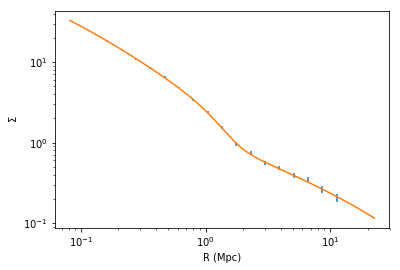

In [63]:
import matplotlib.pyplot as pl

fig, ax  = pl.subplots(1,1)
ax.errorbar(R_vec, data_vec, yerr = np.sqrt(np.diag(cov)), ls = 'None')
ax.plot(R_hires, model_hires)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R (Mpc)')
ax.set_ylabel(r'$\Sigma$')

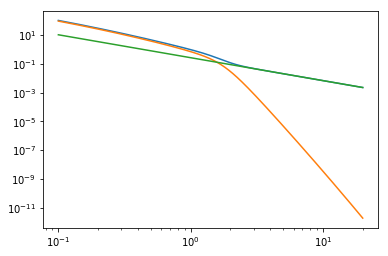

In [64]:
rr = np.exp(np.linspace(np.log(0.1), np.log(20.), num = 500))
rho, rho_onehalo, rho_outer, f_trans = rho_profile(rr, best_params, model_info)

figr, axr = pl.subplots(1,1)
axr.plot(rr, rho, label = 'total')
axr.plot(rr, rho_onehalo, label = 'onehalo')
axr.plot(rr, rho_outer, label = 'total')

axr.set_xscale('log')
axr.set_yscale('log')

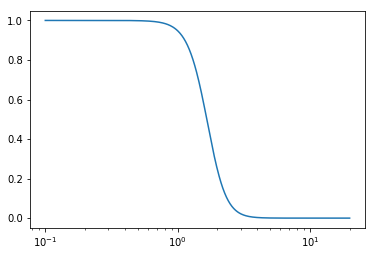

In [65]:
pl.semilogx(rr,f_trans)

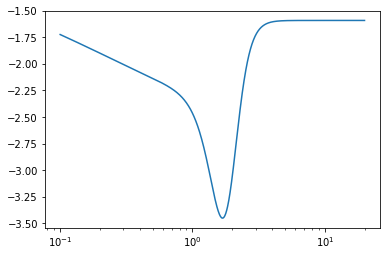

In [67]:
slope = get_slope_sg(rr, rho)[1]
r_slope = np.exp(get_slope_sg(rr, rho)[0])

pl.semilogx(r_slope, slope)

In [68]:
# nwalkers = 128
# start_p0 = best_params
# ndim = len(start_p0)

# #Set up initial positions
# p0_walkers = [np.random.randn(ndim)*0.05 + start_p0 for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior_sigma, args = args)

# print "Running sampler..."
# num_samps = 500
# sampler.run_mcmc(p0_walkers, num_samps)
# print "Done running sampler"


In [69]:
# chain = sampler.flatchain
# lnlike = sampler.flatlnprobability

# chain_data = {'chain':chain, 'lnlike':lnlike, 'start_p0':start_p0, 'R_vec':R_vec, 'data_vec':data_vec, 'cov':cov, 'R_ML':R_hires, 'model_ML':model_hires,'model_info':model_info, 'minR_withh':minR_withh, 'maxR_withh':maxR_withh, 'is_deltasigma':is_deltasigma}


# Next try DeltaSigma

In [70]:
infile = np.load('../cc_measurements/final/splashback_delta_sigma_cov_DeltaSigma.npz')

In [71]:
h0 = 0.7
minR_withh = 0.2
maxR_withh = 10.0

#log alpha, log rho_s, log rho_0, log r_s, s_e, log r_t, log beta, log gamma, f_mis, lnc_mis
p0_splash = np.array([-0.7233399 ,  1.2320193 - 0.3 , -0.81458972 - 0.3, -0.46549158,  1.62975201,\
                      0.30102756,  0.6082444 ,  0.84419774,  6., 0.2570068 , -1.15657301])
p0_nosplash = np.array([-1.08884226, 1.50498118, -0.78881006,-0.60631178,  1.58169303, 0., 0.22  , -1.13 ])

#model choices
with_splashback = True
do_miscentering = True
is_deltasigma = True

miscentering_prior_type = 'freedes' #none, fixeddes, fixedsdss, freedes, freesdss, freesdssaggressive, freesdssloose
alpha_prior_type = 'normal' #normal or tight
profile_type = 'dk' #dk or nfw
z_max = 40./h0

#Bounds
bound_alpha = (-5, 5.)
bound_rho_s = (None, None)
bound_rho_0 = (None, None)
bound_r_s = (np.log10(0.1/h0), np.log10(5.0/h0))
bound_s_e = (-6., 6.)
bound_r_t = (np.log10(0.4/h0), np.log10(5.0/h0))
bound_beta = (None, None)
bound_gamma = (None, None)
bound_fmis = (0.01, 0.99)
bound_lnc = (-20., 5.)

bound_integral_R_min = (None, None)
bounds_splash = (bound_alpha, bound_rho_s, bound_rho_0, bound_r_s, bound_s_e, bound_r_t, \
                 bound_beta, bound_gamma, bound_integral_R_min, bound_fmis, bound_lnc)
bounds_nosplash = (bound_alpha, bound_rho_s, bound_rho_0, bound_r_s, bound_s_e, \
                   bound_integral_R_min, bound_fmis, bound_lnc)


In [72]:
R_vec_orig = infile['R']
data_vec_orig = infile['DS_xi_mean']/1.0e12
cov_orig = infile['cov_xi']/(1.0e24)
R_lambda = infile['mean_rlambda_com']

#Restrict data
good_range = np.where((R_vec_orig*h0 > minR_withh) & (R_vec_orig*h0 < maxR_withh))[0]
R_vec = R_vec_orig[good_range]
data_vec = data_vec_orig[good_range]
cov = (cov_orig[good_range,:])[:,good_range]
detcov = np.linalg.det(cov) # determinant 
invcov = np.linalg.inv(cov) # inverse covariane

In [73]:
model_info = {'h0':h0, 'with_splashback':with_splashback, 'profile_type':profile_type, \
              'miscentering_prior_type':miscentering_prior_type, 'do_miscentering':do_miscentering,\
              'alpha_prior_type':alpha_prior_type, 'z_max':z_max, 'is_deltasigma':is_deltasigma}
model_info['R_lambda'] = R_lambda
minR_deltasig = 0.2/h0
boost_factor_choice = 'fiducial' #fiducial, high, none
model_info['minR_deltasig'] = minR_deltasig
model_info['boost_factor_choice'] = boost_factor_choice

data_info = {'rad_vec':R_vec, 'data_vec':data_vec, 'invcov':invcov, 'detcov':detcov}

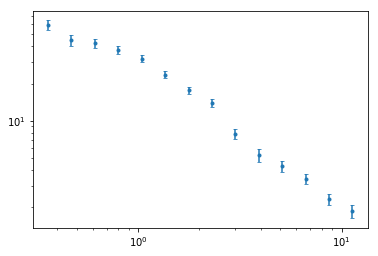

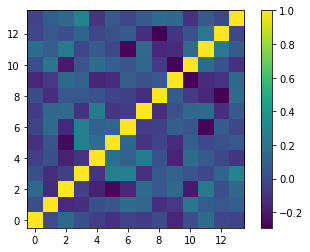

In [74]:
pl.figure()
pl.errorbar(R_vec, data_vec, yerr=np.diag(cov)**0.5, marker='.', fmt='.', capthick=0.8, capsize=2.2)
pl.xscale('log')
pl.yscale('log')

cov_norm = cov.copy()
for i in range(len(cov)):
    for j in range(len(cov)):
        cov_norm[i][j] /= (cov[i][i]*cov[j][j])**0.5

pl.figure()
pl.imshow(cov_norm)
pl.colorbar()

In [75]:
def get_boost(rad_vec, boost_factor_choice):
    if (boost_factor_choice == 'fiducial'):
        B_0 = 10.**(-1.399)
    if (boost_factor_choice == 'high'):
        B_0 = 2.0*10.**(-1.399)
    if (boost_factor_choice == 'none'):
        B_0 = 0.
    mean_lambda = 31.8
    mean_z = 0.40867
    C_lambda = 0.92
    D_z = -4.0
    E_R = -0.98
    lambda_0 = 30.
    z_0 = 0.5
    R_0 = 0.5*(1.+mean_z)
    lambda_factor = ((mean_lambda/lambda_0)**(C_lambda))
    z_factor = ((1.+mean_z)/(1.+z_0))**D_z
    R_factor = (rad_vec/R_0)**E_R
    boost_factor = 1. + B_0**lambda_factor*z_factor*R_factor
    return boost_factor


In [76]:
def get_priors(param_vec, model_info):
    miscentering_prior_type = model_info['miscentering_prior_type']
    do_miscentering = model_info['do_miscentering']
    alpha_prior_type = model_info['alpha_prior_type']
    with_splashback = model_info['with_splashback']
    is_deltasigma = model_info['is_deltasigma']
    

    min_logrs = np.log10(0.1/0.7)
    max_logrs = np.log10(5.0/0.7)
    if (not is_deltasigma):
        min_logrt = np.log10(0.1/0.7)
        max_logrt = np.log10(5.0/0.7)
    if (is_deltasigma):
        min_logrt = np.log10(0.1/0.7)
        max_logrt = np.log10(5.0/0.7)
    min_se = 1.0
    max_se = 10.0

    logalpha = param_vec[0]
    logrho_s = param_vec[1]
    logrho_0 = param_vec[2]
    logr_s = param_vec[3]
    s_e = param_vec[4]

    if ((logr_s < min_logrs) or (logr_s > max_logrs)):
        lnprior_rs = -1.0e10
    else:
        lnprior_rs =  np.log(1./(max_logrs-min_logrs))
    if ((s_e < min_se) or (s_e > max_se)):
        lnprior_se = -1.0e10
    else:
        lnprior_se = np.log(1./(max_se - min_se))

    mean_logalpha = np.log10(0.19)
    #777777777777777777777
    if (alpha_prior_type == 'normal'):
        #This used to be 0.6
        sigma_logalpha = 0.2 
    if (alpha_prior_type == 'tight'):
        sigma_logalpa = 0.1
    if (is_deltasigma):
        sigma_logalpha = 0.1 #0.05
    #777777777777777777777        
    #if (is_deltasigma):
    #    mean_se = 1.6
    #    sigma_se = 0.15 #0.05
    #    lnnorm_se = -np.log(np.sqrt(2.*(sigma_se**2.)*np.pi))
    #    lnprior_se = lnnorm_se-0.5*((s_e - mean_se)**2.)/sigma_se**2.
    lnnorm_logalpha = -np.log(np.sqrt(2.*(sigma_logalpha**2.)*np.pi))
    lnprior_alpha = lnnorm_logalpha-0.5*((logalpha - mean_logalpha)**2.)/sigma_logalpha**2.

    lnprior_splash = 0.0
    if (with_splashback):
        logr_t = param_vec[5]
        logbeta = param_vec[6]
        loggamma = param_vec[7]
        lnprior_rt = 0.0
        lnprior_beta = 0.0
        lnprior_gamma = 0.0
        if ((logr_t > max_logrt) or (logr_t < min_logrt)):
            lnprior_rt = -1.0e10
        else:
            #normalization
            lnprior_rt = np.log(1./(max_logrt - min_logrt))
            mean_logbeta = np.log10(4.)
            sigma_logbeta = 0.2
            lnnorm_logbeta = -np.log(np.sqrt(2.*(sigma_logbeta**2.)*np.pi))
            mean_loggamma = np.log10(6.0)
            sigma_loggamma = 0.2
            lnnorm_loggamma = -np.log(np.sqrt(2.*(sigma_loggamma**2.)*np.pi))
            lnprior_beta =  lnnorm_logbeta -0.5*((logbeta - mean_logbeta)**2.)/sigma_logbeta**2.
            lnprior_gamma = lnnorm_loggamma -0.5*((loggamma - mean_loggamma)**2.)/sigma_loggamma**2.
        lnprior_splash = lnprior_rt + lnprior_beta + lnprior_gamma

    lnprior_miscentering = 0.0
    if (do_miscentering):
        f_mis = param_vec[-2]
        lnc_mis = param_vec[-1]

        if ((f_mis < 0.01) or (f_mis > 0.99) or (lnc_mis < -20.) or (lnc_mis > 5.0)):
            lnprior_miscentering = -1.0e10
        else:
            # DES
            if (miscentering_prior_type == 'freedes'):
                mean_lncmis = -1.13
                sigma_lncmis = 0.22
                mean_fmis = 0.22
                sigma_fmis = 0.11
            # SDSS
            if (miscentering_prior_type == 'freesdss'):
                mean_lncmis = -0.916
                sigma_lncmis = 0.22
                mean_fmis = 0.2
                sigma_fmis = 0.07
            if (miscentering_prior_type == 'freesdssloose'):
                mean_lncmis = -0.916
                sigma_lncmis = 0.44
                mean_fmis = 0.2
                sigma_fmis = 0.14
            lnnorm_lncmis = -np.log(np.sqrt(2.*(sigma_lncmis**2.)*np.pi))
            lnnorm_fmis = -np.log(np.sqrt(2.*(sigma_fmis**2.)*np.pi))
            lnprior_lncmis = lnnorm_lncmis -0.5*((lnc_mis - mean_lncmis)**2.)/sigma_lncmis**2.
            lnprior_fmis = lnnorm_fmis -0.5*((f_mis - mean_fmis)**2.)/sigma_fmis**2.
            lnprior_miscentering = lnprior_lncmis + lnprior_fmis

    lnpriors = lnprior_rs + lnprior_se + lnprior_alpha + lnprior_splash + lnprior_miscentering

    return lnpriors

In [77]:
def deltasigma_model(params, R_array, model_info):
    h0 = model_info['h0']
    with_splashback = model_info['with_splashback']
    profile_type = model_info['profile_type']
    miscentering_prior_type = model_info['miscentering_prior_type']
    do_miscentering = model_info['do_miscentering']
    alpha_prior_type = model_info['alpha_prior_type']
    minR = model_info['minR_deltasig']
    R_lambda = model_info['R_lambda']
    integral_R_min = params[-3]
    
    if (do_miscentering):
        f_mis = params[-2]
        lnc_mis = params[-1]
        min_R_temp = minR
        max_R_temp = 1.2*np.max(R_array)
        num_R_temp = len(R_array)+100
        R_temp = np.exp(np.linspace(np.log(min_R_temp), np.log(max_R_temp), num = num_R_temp))
        import time
        t1 = time.time()
        sigma_model_nomiscentering = sigma_profile(params, R_temp, model_info)
        t2 = time.time()
        sigma_mis = sigma_miscentered(R_temp, R_temp, sigma_model_nomiscentering, f_mis, lnc_mis, R_lambda)
        t3 =time.time()
        deltasigma_model_nomiscentering = sigma_to_deltasigma(R_array, R_temp, sigma_model_nomiscentering, params, minR, integral_R_min)
        deltasigma_model_mis = sigma_to_deltasigma(R_array, R_temp, sigma_mis, params, minR, integral_R_min)
        deltasigma_model = (1. - f_mis)*deltasigma_model_nomiscentering + f_mis*deltasigma_model_mis
        t4 = time.time()
        #pdb.set_trace()
    else:
        min_R_temp = minR
        max_R_temp = 1.2*np.max(R_array)
        num_R_temp = len(R_array)+100
        R_temp = np.exp(np.linspace(np.log(min_R_temp), np.log(max_R_temp), num = num_R_temp))
        sigma_model = sigma_profile(params, R_temp, model_info)
        deltasigma_model = sigma_to_deltasigma(R_array, R_temp, sigma_model, params, minR, integral_R_min)

    return deltasigma_model

In [78]:
def sigma_to_deltasigma(R_output, R_Sigma, Sigma, params, minR, integral_R_min):
    dsig = np.zeros(len(R_output))
    temp = np.copy(R_Sigma)
    temp[0] *= 0.999999
    temp[-1] *= 1.000001
    lnsigma_interp_func = interpolate.interp1d(np.log(temp), np.log(Sigma))
    to_integrate_func = interpolate.interp1d(temp, Sigma*R_Sigma)

    do_fast = True
    if (not do_fast):
        dsig = np.zeros(len(R_output))
        for i in range(len(R_output)):
            if (minR < np.min(temp) or np.min(R_output) < np.min(temp)): 
                pdb.set_trace()
            integral_result = integrate.quad(to_integrate_func, minR, R_output[i], epsabs=1.0e-05, epsrel=1.0e-05)
            dsig[i] = 2.*(integral_result[0] + integral_R_min)/(R_output[i]**2.) - np.exp(lnsigma_interp_func(np.log(R_output[i])))
    if (do_fast):
        minR_tointegrate = minR
        numR_tointegrate = 10000
        R_tointegrate = np.exp(np.linspace(np.log(minR_tointegrate), np.log(np.max(R_output*1.0001)), num = numR_tointegrate))
        dR_tointegrate = R_tointegrate[1:] - R_tointegrate[:-1]
        func_evals = to_integrate_func(R_tointegrate)
        integral = np.cumsum(0.5*dR_tointegrate*(func_evals[1:] + func_evals[:-1]))
        #Make integral at minR equal to zero
        integral_func = interpolate.interp1d(np.append([minR],R_tointegrate[1:]),np.append([0],integral))
        try:
            dsig = 2.*(integral_func(R_output) + integral_R_min)/R_output**2. -  np.exp(lnsigma_interp_func(np.log(R_output)))
        except:
            print "interp problems!"
            pdb.set_trace()

    return dsig

In [79]:
def lnposterior_deltasigma(param_vec, data_info, model_info, return_model = False, return_num = 500):
    print "param_vec = ", param_vec
    rad_vec = data_info['rad_vec']
    data_vec = data_info['data_vec']
    invcov = data_info['invcov']
    detcov = data_info['detcov']

    boost_factor_choice = model_info['boost_factor_choice']

    #Get DeltaSigma(R) model
    deltasigma_model_at_R = deltasigma_model(param_vec, rad_vec, model_info)
    #boost factor
    boost_factor = get_boost(rad_vec, boost_factor_choice)
    model_dsig = (1./boost_factor)*deltasigma_model_at_R

    #Calculate priors
    lnpriors = get_priors(param_vec, model_info)
    
    diff = data_vec - model_dsig
    lnlike = -0.5*(len(data_vec)*np.log(2.*np.pi) + np.log(detcov)) -0.5*np.dot(diff, np.dot(invcov, diff))
    lnposterior = lnlike + lnpriors

    print "lnposterior = ", lnposterior
    if (not return_model):
        return lnposterior
    else:
        R_hires = np.exp(np.linspace(np.log(np.min(rad_vec)), np.log(2.*np.max(rad_vec)), num = return_num))
        model_hires_noboost = deltasigma_model(param_vec, R_hires, model_info)
        boost_hires = get_boost(R_hires, boost_factor_choice)
        model_hires = (1./boost_hires)*model_hires_noboost
        
        return lnposterior, R_hires, model_hires


In [80]:
if (with_splashback):
    p0 = np.copy(p0_splash)
    bounds = bounds_splash
else:
    p0 = np.copy(p0_nosplash)
    bounds_nosplash

    #Do max likelihood calculation
args = (data_info, model_info)
nll = lambda *args: -lnposterior_deltasigma(*args)

In [81]:
# print p0
# print args
# print bounds

In [82]:
method = 'SLSQP'
result = op.minimize(nll, p0, args=args, method = method, options = {'maxiter':100}, bounds = bounds)

param_vec =  [-0.7233399   0.9320193  -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  6.          0.2570068  -1.15657301]
lnposterior =  -433.281584416
param_vec =  [-0.7233399   0.9320193  -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  6.          0.2570068  -1.15657301]
lnposterior =  -433.281584416
param_vec =  [-0.72333989  0.9320193  -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  6.          0.2570068  -1.15657301]
lnposterior =  -433.281584781
param_vec =  [-0.7233399   0.93201931 -1.11458972 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  6.          0.2570068  -1.15657301]
lnposterior =  -433.281582597
param_vec =  [-0.7233399   0.9320193  -1.11458971 -0.46549158  1.62975201  0.30102756
  0.6082444   0.84419774  6.          0.2570068  -1.15657301]
lnposterior =  -433.281583271
param_vec =  [-0.7233399   0.9320193  -1.11458972 -0.46549157  1.62975201  0.30102756
  0.6082444   0.84419774

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power


lnposterior =  -3.66784907207e+25
param_vec =  [-0.7661065   2.15306537 -0.34581981 -0.45229794  1.67345449  0.306556
  0.9976862   0.63319219  6.13486187  0.26433673 -1.19305185]
lnposterior =  -187.409629028
param_vec =  [-0.7661065   2.15306537 -0.34581981 -0.45229794  1.67345449  0.306556
  0.9976862   0.63319219  6.13486187  0.26433673 -1.19305185]
lnposterior =  -187.409629028
param_vec =  [-0.76610649  2.15306537 -0.34581981 -0.45229794  1.67345449  0.306556
  0.9976862   0.63319219  6.13486187  0.26433673 -1.19305185]
lnposterior =  -187.409623057
param_vec =  [-0.7661065   2.15306538 -0.34581981 -0.45229794  1.67345449  0.306556
  0.9976862   0.63319219  6.13486187  0.26433673 -1.19305185]
lnposterior =  -187.409653817
param_vec =  [-0.7661065   2.15306537 -0.34581979 -0.45229794  1.67345449  0.306556
  0.9976862   0.63319219  6.13486187  0.26433673 -1.19305185]
lnposterior =  -187.409632523
param_vec =  [-0.7661065   2.15306537 -0.34581981 -0.45229793  1.67345449  0.306556
  

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


param_vec =  [-0.70844544  2.0107603   0.31427336 -0.45622595  1.71671995  0.31202916
  1.36876109  0.4769645   6.30733974  0.26179336 -1.21388139]
lnposterior =  -564.021008059
param_vec =  [-0.76034039  2.13883486 -0.27981049 -0.45269074  1.67778104  0.30710332
  1.03479368  0.61756942  6.15210966  0.2640824  -1.19513481]
lnposterior =  -181.723827501
param_vec =  [-0.76034039  2.13883486 -0.27981049 -0.45269074  1.67778104  0.30710332
  1.03479368  0.61756942  6.15210966  0.2640824  -1.19513481]
lnposterior =  -181.723827501
param_vec =  [-0.76034038  2.13883486 -0.27981049 -0.45269074  1.67778104  0.30710332
  1.03479368  0.61756942  6.15210966  0.2640824  -1.19513481]
lnposterior =  -181.723821542
param_vec =  [-0.76034039  2.13883487 -0.27981049 -0.45269074  1.67778104  0.30710332
  1.03479368  0.61756942  6.15210966  0.2640824  -1.19513481]
lnposterior =  -181.723851074
param_vec =  [-0.76034039  2.13883486 -0.27981048 -0.45269074  1.67778104  0.30710332
  1.03479368  0.61756942

In [83]:
best_params = result.x
best_lnlike = -result.fun

lnlike_temp, R_hires, model_hires = lnposterior_deltasigma(best_params, data_info, model_info, return_model = True)

param_vec =  [-0.74981209  2.74845646 -0.24743488 -0.78078477  1.00000015  0.62981033
  0.55901711  0.97345365  7.40269771  0.24309609 -1.0685955 ]
lnposterior =  -17.3724123289


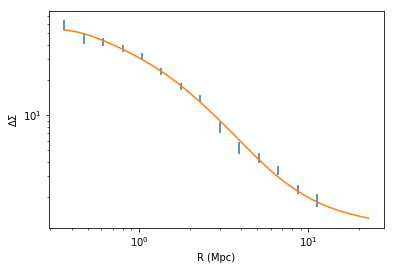

In [84]:
import matplotlib.pyplot as pl

fig, ax  = pl.subplots(1,1)
ax.errorbar(R_vec, data_vec, yerr = np.sqrt(np.diag(cov)), ls = 'None')
ax.plot(R_hires, model_hires)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('R (Mpc)')
ax.set_ylabel(r'$\Delta\Sigma$')

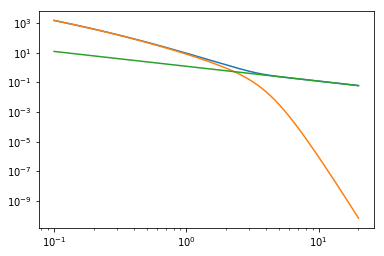

In [85]:
rr = np.exp(np.linspace(np.log(0.1), np.log(20.), num = 500))
rho, rho_onehalo, rho_outer, f_trans = rho_profile(rr, best_params, model_info)

figr, axr = pl.subplots(1,1)
axr.plot(rr, rho, label = 'total')
axr.plot(rr, rho_onehalo, label = 'onehalo')
axr.plot(rr, rho_outer, label = 'total')

axr.set_xscale('log')
axr.set_yscale('log')

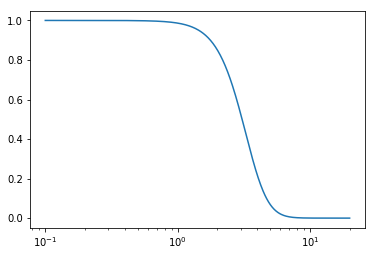

In [86]:
pl.semilogx(rr,f_trans)

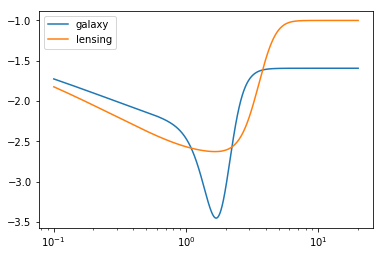

In [87]:
slope2 = get_slope_sg(rr, rho)[1]
r_slope2 = np.exp(get_slope_sg(rr, rho)[0])

pl.semilogx(r_slope, slope, label='galaxy')
pl.semilogx(r_slope2, slope2, label='lensing')
pl.legend()